# **Heart Disease Prediction**

## **Baseline Model**

This notebook focuses on creating a **baseline model** using a heuristic approach to serve as a reference for comparing future machine learning models. The goal is to establish a simple yet informative starting point that helps evaluate improvements in predictive performance.

All steps will be implemented using **scikit-learn** and other relevant libraries to ensure a structured and reproducible workflow.

`Simón Correa Marín`


The model will be based on the following rules based on the EDA and other analysis.

1. Chest pain **'asymptomatic'** has 73.42% influence is heart disease prediction true.
2. If it is a **man** it is most likely to have heart disease.
3. If **fbs > 120mg/dL (True)** then it is most likely to not having heart disease.
4. If the patient’s **age is between 50 and 60 years** its most likely yo have a heart disease.
5. Heart disease likely happens to people with **max_hr (maximum heart rate) between 120 and 160**
6. If **that is reversable** it is most likely to have heart disease.


### **1. Import Libraries and Configurations**


In [87]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline

### **2. Load Data**


In [88]:
DATA_DIR = Path.cwd().resolve().parents[0] / "data"

hd_df = pd.read_parquet(DATA_DIR / "02_intermediate/hd_type_fixed.parquet", engine="pyarrow")

In [89]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)

Pandas version:  2.2.3


### **3. Data Preparation**


Based on the rules above, for the heuristic model only 6 columns are needed: `chest_pain`, `sex`,`fbs`,`age`,`max_hr`,`thal`


In [90]:
selected_features = ["chest_pain", "sex", "fbs", "age", "max_hr", "thal", "disease"]
hd_features = hd_df[selected_features]
hd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6848 entries, 0 to 6847
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   chest_pain  6648 non-null   category
 1   sex         6692 non-null   category
 2   fbs         6848 non-null   bool    
 3   age         6763 non-null   float64 
 4   max_hr      6453 non-null   float64 
 5   thal        6552 non-null   category
 6   disease     6848 non-null   bool    
dtypes: bool(2), category(3), float64(2)
memory usage: 141.0 KB


In [91]:
hd_features.isna().sum()

chest_pain    200
sex           156
fbs             0
age            85
max_hr        395
thal          296
disease         0
dtype: int64

In [92]:
# Change target data type to int (0,1)
hd_features.loc[:, "disease"] = hd_features["disease"].astype(int)

/var/folders/x2/wzyt5ll12z77w4qw_gm51n8w0000gn/T/ipykernel_28929/760228322.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 0 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  hd_features.loc[:, "disease"] = hd_features["disease"].astype(int)


#### **Duplicated Data**


In [93]:
len(hd_features.drop_duplicates())

474

In [94]:
hd_features = hd_features.drop_duplicates()
hd_features.shape

(474, 7)

Compared to the duplicates in the whole dataset (508) I'll be using the dataset with the duplicated rows dropped.


In [95]:
hd_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474 entries, 0 to 2423
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   chest_pain  417 non-null    category
 1   sex         432 non-null    category
 2   fbs         474 non-null    bool    
 3   age         457 non-null    float64 
 4   max_hr      363 non-null    float64 
 5   thal        409 non-null    category
 6   disease     474 non-null    int64   
dtypes: bool(1), category(3), float64(2), int64(1)
memory usage: 17.1 KB


In [96]:
hd_features.sample(10)

,chest_pain,sex,fbs,age,max_hr,thal,disease
638,asymptomatic,Male,False,40.0,NaN,NaN,1
681,nonanginal,Female,False,64.0,133.0,reversable,0
1029,NaN,NaN,True,55.0,NaN,normal,0
194,asymptomatic,Female,False,51.0,142.0,reversable,1
148,asymptomatic,Male,False,64.0,105.0,reversable,0
135,asymptomatic,Male,False,66.0,132.0,normal,1
2239,nonanginal,Male,True,59.0,NaN,NaN,1
1903,nontypical,Female,False,55.0,166.0,normal,0
618,nonanginal,Female,False,42.0,173.0,normal,1
0,nontypical,Male,False,52.0,158.0,normal,0


### **4. Feature Engineering**


In [97]:
nom_categorical_cols = ["chest_pain", "thal", "sex"]
disc_numerical_cols = ["age", "max_hr"]
boolean_cols = ["fbs"]  # Doesn't need to be transformed (no nans)

#### **Pipeline**


In [ ]:
from sklearn.preprocessing import FunctionTransformer

numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

nom_categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

boolean_pipe = Pipeline(
    steps=[
        (
            "to_int",
            FunctionTransformer(lambda x: x.astype("int64"), feature_names_out="one-to-one"),
        ),
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, disc_numerical_cols),
        ("nominal_categoric", nom_categorical_pipe, nom_categorical_cols),
        ("boolean", boolean_pipe, boolean_cols),
    ]
)

In [99]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'max_hr']),
                                ('nominal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['chest_pain', 'thal', 'sex']),
                                ('boolean',
                                 Pipeline(steps=[('to_int',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x124abd760>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['fbs'])])

**Data preprocessing example**


In [100]:
data_example = hd_features.drop(columns="disease").sample(10, random_state=42)
data_example

,chest_pain,sex,fbs,age,max_hr,thal
1899,asymptomatic,Male,True,55.0,NaN,reversable
2042,nonanginal,Female,False,76.0,NaN,NaN
10,asymptomatic,Female,False,62.0,163.0,normal
2362,nontypical,Female,False,45.0,138.0,NaN
42,nonanginal,Male,False,44.0,169.0,normal
36,asymptomatic,Male,False,47.0,143.0,normal
2294,asymptomatic,Female,False,71.0,NaN,NaN
532,asymptomatic,Male,False,61.0,161.0,reversable
91,asymptomatic,Male,False,44.0,177.0,normal
59,typical,Female,True,58.0,NaN,NaN


In [101]:
preprocessor.fit_transform(data_example)

array([[55.0, 162.0, 'asymptomatic', 'reversable', 'Male', 1],
       [76.0, 162.0, 'nonanginal', 'normal', 'Female', 0],
       [62.0, 163.0, 'asymptomatic', 'normal', 'Female', 0],
       [45.0, 138.0, 'nontypical', 'normal', 'Female', 0],
       [44.0, 169.0, 'nonanginal', 'normal', 'Male', 0],
       [47.0, 143.0, 'asymptomatic', 'normal', 'Male', 0],
       [71.0, 162.0, 'asymptomatic', 'normal', 'Female', 0],
       [61.0, 161.0, 'asymptomatic', 'reversable', 'Male', 0],
       [44.0, 177.0, 'asymptomatic', 'normal', 'Male', 0],
       [58.0, 162.0, 'typical', 'normal', 'Female', 1]], dtype=object)

### **5. Train/Test split**


In [102]:
X_features = hd_features.drop("disease", axis="columns")
Y_target = hd_features["disease"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [103]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((379, 6), (379,), (95, 6), (95,))

**Data preprocessing**


In [104]:
transformed_data = preprocessor.fit(x_train)

In [105]:
feature_names = preprocessor.get_feature_names_out()

# Transform X_test with preprocessor and pandas output set
x_train_transformed = preprocessor.transform(x_train)
x_train_transformed = pd.DataFrame(x_train_transformed, columns=feature_names)
x_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   numeric__age                   379 non-null    object
 1   numeric__max_hr                379 non-null    object
 2   nominal_categoric__chest_pain  379 non-null    object
 3   nominal_categoric__thal        379 non-null    object
 4   nominal_categoric__sex         379 non-null    object
 5   boolean__fbs                   379 non-null    object
dtypes: object(6)
memory usage: 17.9+ KB


### **6. Model**


In [106]:
class HeuristicModel(BaseEstimator, ClassifierMixin):
    def fit(self, _, y=None):
        if y is not None:
            self.classes_ = np.unique(y)
        return self

    def predict(self, X) -> np.ndarray:
        CHEST_PAIN_THRESHOLD = "asymptomatic"  # High risk if chest pain is asymptomatic
        SEX_HIGH_RISK = "Male"  # Males are at higher risk
        FBS_THRESHOLD = 0  # If fasting blood sugar is not > 120 mg/dL, lower risk
        AGE_LOW, AGE_HIGH = 55, 65  # High-risk age range
        MAX_HR_LOW, MAX_HR_HIGH = 150, 170  # Low-risk max heart rate range
        THAL_HIGH_RISK = "normal"  # Thal normal results indicating no risk

        predictions = []
        for row in X:
            if (
                (AGE_LOW <= row[0] <= AGE_HIGH)
                or (row[1] < MAX_HR_LOW)
                or (row[1] > MAX_HR_HIGH)
                or (row[2] == CHEST_PAIN_THRESHOLD)
                or (row[3] != THAL_HIGH_RISK)
                or (row[4] == SEX_HIGH_RISK)
                or (row[5] != FBS_THRESHOLD)
            ):
                predictions.append(1)
            else:
                predictions.append(0)

        return np.array(predictions)

### **7. Predict and Evaluation**


accuracy - CV mean: 0.5540540540540541, CV std: 0.07400820819695615
accuracy - Train score: 0.554089709762533
f1 - CV mean: 0.6958565904543761, CV std: 0.06169855491880738
f1 - Train score: 0.554089709762533
precision - CV mean: 0.5463868476771702, CV std: 0.07380963404791048
precision - Train score: 0.554089709762533
recall - CV mean: 0.9720374552983249, CV std: 0.03930801120044392
recall - Train score: 0.554089709762533


<Axes: title={'center': 'Cross Validation Boxplot'}, ylabel='Score'>

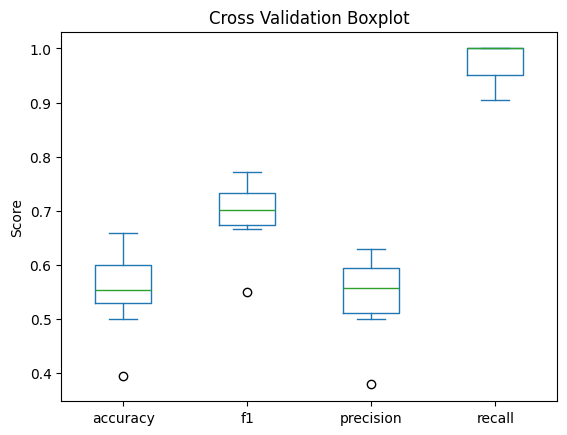

In [107]:
# Model
model = HeuristicModel()

# Evaluation metrics
scoring_metrics = ["accuracy", "f1", "precision", "recall"]

# KFold for the cross-validation
kfold = KFold(n_splits=10)

# Model pipeline = preprocessor + model
model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Variable to store the results of the cross-validation
cv_results = {}
train_results = {}

# Cross-validation evaluation for each metric
for metric in scoring_metrics:
    cv_results[metric] = cross_val_score(model_pipe, x_train, y_train, cv=kfold, scoring=metric)
    # Evaluate on the training set
    model_pipe.fit(x_train, y_train)
    train_results[metric] = model_pipe.score(x_train, y_train)

# Convert results into a pandas DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Print the mean and standard deviation for each metric
for metric_name in scoring_metrics:
    print(
        f"{metric_name} - CV mean: {cv_results_df[metric_name].mean()}, "
        f"CV std: {cv_results_df[metric_name].std()}"
    )
    print(f"{metric_name} - Train score: {train_results[metric_name]}")

# Create a boxplot for the cross-validation results of each metric
cv_results_df.plot.box(title="Cross Validation Boxplot", ylabel="Score")

<Axes: title={'center': 'Training vs Cross-Validation Scores'}, xlabel='Metric', ylabel='Score'>

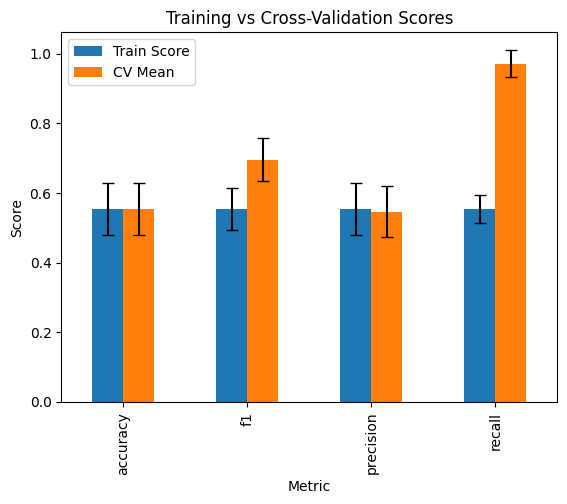

In [108]:
# Create a DataFrame for the training and cross-validation metrics
metrics_df = pd.DataFrame(
    {
        "Metric": scoring_metrics,
        "Train Score": [train_results[metric] for metric in scoring_metrics],
        "CV Mean": [cv_results_df[metric].mean() for metric in scoring_metrics],
        "CV Std": [cv_results_df[metric].std() for metric in scoring_metrics],
    }
)

# Create a bar plot for the training and cross-validation metrics
metrics_df.plot(
    kind="bar",
    x="Metric",
    y=["Train Score", "CV Mean"],
    yerr="CV Std",
    title="Training vs Cross-Validation Scores",
    ylabel="Score",
    capsize=4,
)

### **Analysis of the Results of All Metrics**


#### **Accuracy**

- **CV Mean:** 0.5541
- **CV Std:** 0.0740
- **Train Score:** 0.5541

**Interpretation:**  
The accuracy on the training set is nearly identical to the cross-validation mean accuracy, indicating that the model generalizes similarly on training and validation data. The standard deviation suggests moderate variability in accuracy across different folds, meaning the model's performance is not entirely stable.

#### **F1 Score**

- **CV Mean:** 0.6959
- **CV Std:** 0.0617
- **Train Score:** 0.5541

**Interpretation:**  
The F1 score on the training set is noticeably lower than the cross-validation mean F1 score. This suggests that while the model achieves a balanced precision and recall across validation sets, its ability to do so on the training set is not as strong. The standard deviation indicates some variation in F1 score across different folds.

#### **Precision**

- **CV Mean:** 0.5464
- **CV Std:** 0.0738
- **Train Score:** 0.5541

**Interpretation:**  
The precision on the training set is slightly higher than the cross-validation mean precision. The moderate standard deviation implies that precision fluctuates across different validation folds, but not drastically.

#### **Recall**

- **CV Mean:** 0.9720
- **CV Std:** 0.0393
- **Train Score:** 0.5541

**Interpretation:**  
The recall score on cross-validation is very high (0.972), meaning the model correctly identifies most positive cases. However, the recall on the training set is significantly lower, indicating a discrepancy between training and validation performance. The relatively low standard deviation suggests that recall remains consistent across different validation folds.

---

### **Overall Conclusion**

The model exhibits **high recall**, which means it is effective at capturing positive cases, making it well-suited for scenarios where **missing a positive case is critical**, such as heart disease prediction. However, the relatively **low precision and accuracy** indicate a trade-off, where the model classifies a large number of **false positives**. The **moderate variability** in accuracy, precision, and F1 score across folds suggests some inconsistency in performance.


### **8. Final Evaluation**


In [109]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    classification_report,
)

In [110]:
y_pred = model_pipe.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.07      0.12        45
           1       0.54      1.00      0.70        50

    accuracy                           0.56        95
   macro avg       0.77      0.53      0.41        95
weighted avg       0.76      0.56      0.43        95



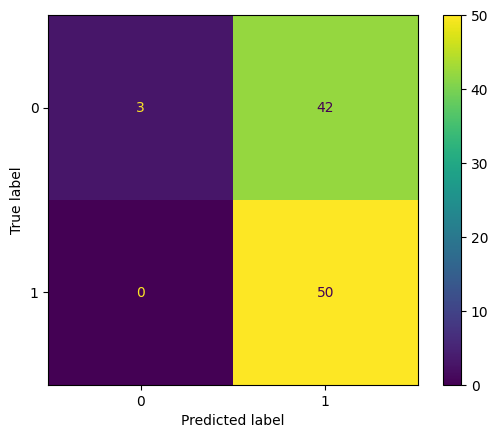

In [111]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

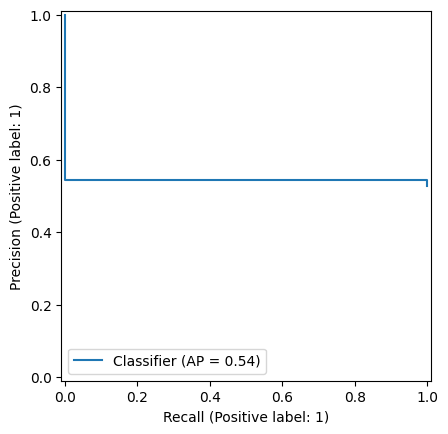

In [112]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

### **Chosen Metric: Recall**

#### **Why Recall?**

For heart disease prediction, **recall** is the most important metric because the primary goal is to **correctly identify as many patients with heart disease as possible**. Missing a case of heart disease (false negative) can have severe consequences, including delayed diagnosis and treatment, which could be life-threatening.

#### **Understanding Recall in This Context**

- **High recall** ensures that most patients who actually have heart disease are correctly classified as positive cases.
- **False negatives (missed cases of heart disease)** are minimized, reducing the risk of undiagnosed conditions.
- **False positives (healthy patients misclassified as having heart disease)** are a less critical issue compared to false negatives because additional medical tests can confirm the diagnosis.

#### **Conclusion**

Since the model's objective is to **prioritize detecting heart disease cases**, **recall is the best metric** for evaluation. A model with high recall ensures that the majority of patients at risk receive further medical attention, ultimately improving early detection and treatment outcomes.


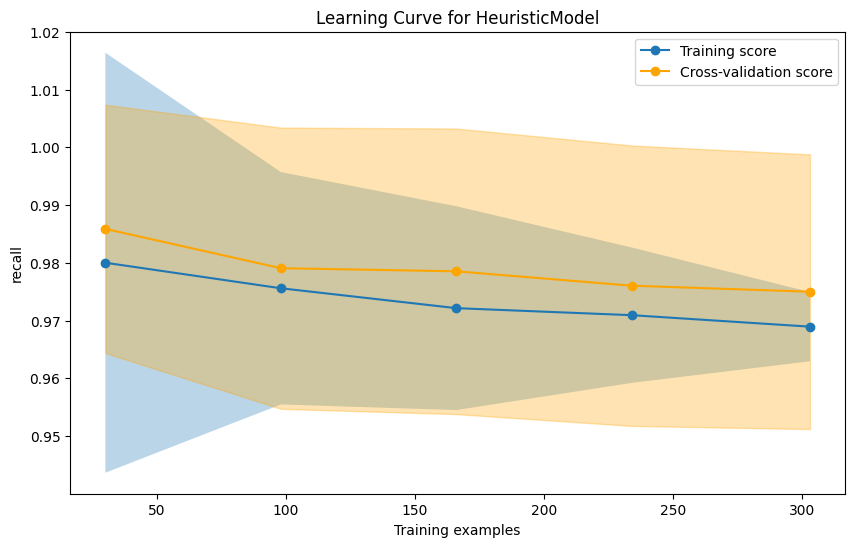

Training Sizes: [ 30  98 166 234 303]
Training Scores Mean: [0.98002496 0.97560164 0.9721567  0.97093954 0.96895279]
Training Scores Std: [0.03636528 0.02012081 0.01764426 0.01171459 0.00599203]
Test Scores Mean: [0.98588337 0.97907512 0.97853612 0.97604363 0.97500309]
Test Scores Std: [0.02150185 0.02434817 0.02472779 0.0242801  0.02378433]


In [113]:
# Define pipeline = preprocessor + model
model = HeuristicModel()
model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "recall"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model_pipe, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange")

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)

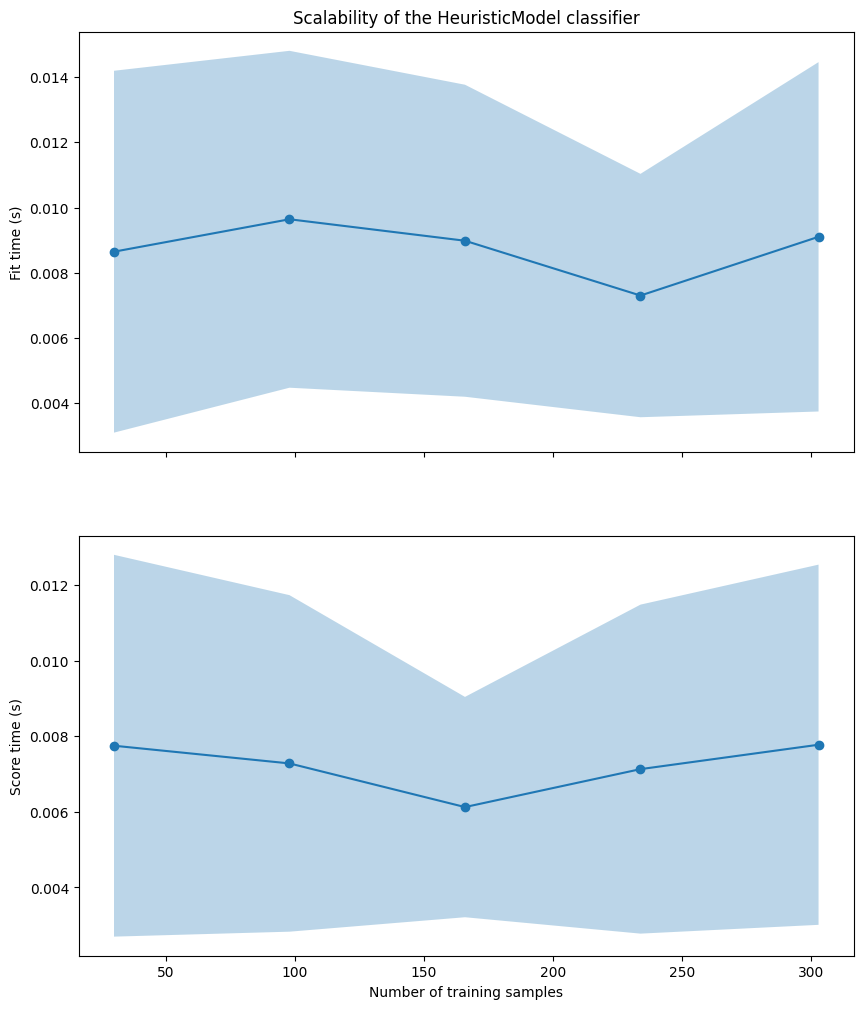

Fit Times Mean: [0.00864674 0.00964081 0.0089828  0.00730305 0.00910325]
Fit Times Std: [0.00554531 0.00516279 0.00478157 0.00372969 0.0053541 ]
Score Times Mean: [0.0077523  0.00728379 0.00612816 0.00713258 0.00777856]
Score Times Std: [0.00505402 0.00445447 0.00291644 0.00435496 0.00476794]


In [114]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title(f"Scalability of the {model.__class__.__name__} classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

### **Interpretation of the Learning Curve based on Recall only**


### **Learning Curve Analysis**

#### **Training Scores**

- **Mean:** [0.9800, 0.9756, 0.9722, 0.9709, 0.9690]
- **Standard Deviation:** [0.0364, 0.0201, 0.0176, 0.0117, 0.0060]

**Interpretation:**  
The training recall score starts high at **0.9800** and slightly decreases to **0.9690** as more data is added.  
The standard deviation decreases as the training size increases, indicating that the model’s performance on the training set becomes more **consistent** with more data.

#### **Test Scores**

- **Mean:** [0.9859, 0.9791, 0.9785, 0.9760, 0.9750]
- **Standard Deviation:** [0.0215, 0.0243, 0.0247, 0.0243, 0.0238]

**Interpretation:**  
The test recall score is **consistently high**, with minor variations, maintaining values around **0.9750 - 0.9859**.  
The standard deviation remains relatively stable, indicating that the model’s **performance on the test set is consistent** across different folds of cross-validation.

#### **Fit Times**

- **Mean:** [0.0086, 0.0096, 0.0090, 0.0073, 0.0091]
- **Standard Deviation:** [0.0055, 0.0052, 0.0048, 0.0037, 0.0054]

**Interpretation:**  
The fit times are **low and stable**, with minor fluctuations as the training size increases.  
The standard deviation is also low, suggesting **consistent training times** across different folds.

#### **Score Times**

- **Mean:** [0.0078, 0.0073, 0.0061, 0.0071, 0.0078]
- **Standard Deviation:** [0.0051, 0.0045, 0.0029, 0.0044, 0.0048]

**Interpretation:**  
The score times remain **low and stable**, with minimal variation as the training size increases.  
The low standard deviation indicates **consistent evaluation times** across different folds.

---

### **Model Performance Evaluation**

| Metric        | NO Heart Disease | Heart Disease | Macro Avg | Weighted Avg |
| ------------- | ---------------- | ------------- | --------- | ------------ |
| **Precision** | 1.00             | 0.54          | 0.77      | 0.76         |
| **Recall**    | 0.07             | 1.00          | 0.53      | 0.56         |
| **F1-Score**  | 0.12             | 0.70          | 0.41      | 0.43         |
| **Accuracy**  | -                | -             | -         | 0.56         |

**Interpretation:**

- The model has a **high recall (1.00) for class 1 (disease)**, meaning it **correctly identifies all positive cases**.
- However, **precision for class 1 (disease) is low (0.54)**, indicating a high **false positive rate**.
- The **recall for class 0 (no disease) is very low (0.07)**, meaning the model **fails to correctly classify most negative cases**.
- The **overall accuracy is 0.56**, suggesting the model is biased towards predicting class 1 (disease).


### **9. Conclusions**

#### **General Results**

**Model Performance:**  
The **training and test recall scores are stable**, indicating that the model performs **consistently well** across both datasets.  
The minimal difference between training and test scores suggests that **the model generalizes well** to unseen data and is **not overfitting**.

**Consistency:**  
The **decreasing standard deviation of the training scores** with more data suggests that the model’s performance on the training set becomes **more stable and reliable** as the dataset grows.  
The **relatively stable standard deviation in test scores** indicates that the model maintains consistent performance across different validation folds.

**Scalability:**  
The **fit and score times are low and stable**, indicating that the model is **computationally efficient** and scales well with increasing training sizes.

**To improveme:**

- The **very low recall for class 0 (0.07)** suggests the model is **heavily biased towards predicting class 1**.
- Increasing **precision for class 1** while improving **recall for class 0** should be a priority.
- Possible solutions include **adjusting decision thresholds**, **balancing the dataset**, or **exploring different algorithms**.
